# Bag-of-Words Classifier Pipeline

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import sklearn.neural_network

# Custom functions 
from utils import (
    print_gridsearch_results, 
    test_on_estimator, 
    plot_cv_train_test, 
    plot_cv_folds, 
    analysis_of_mistakes,
)

RANDOM_STATE = 123

In [2]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Data prep

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# Where to output predictions on the test_set
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
output_dir = 'predictions'

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"x_test_df shape: {x_test_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
x_test_text = x_test_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
x_test_df shape: (600, 2) 
y_train_df shape: (2400, 1) 


## Dataset Exploration

In [4]:
num_train_samples = x_train_text.shape[0]
num_positive_train_samples = np.count_nonzero(y_train == 1)
fraction_positive_train = float(num_positive_train_samples) / float(num_train_samples)


print(f"Total number of training samples = {num_train_samples}")
print(f"Fraction positive training samples = {fraction_positive_train}")


Total number of training samples = 2400
Fraction positive training samples = 0.5


## Define a stable SKF CV-splitter and a TF-IDF Vectorizer

In [5]:
cv_splitter = sklearn.model_selection.StratifiedKFold(n_splits=5)

In [83]:
tf_vectorizer = TfidfVectorizer(stop_words='english')

# Static Parameters based on earlier grid_search 
tf_vectorizer.set_params(min_df = 1, ngram_range = (1,2))

# Set the tuple for the pipeline
tf_pipeline_tuple = ("tf", tf_vectorizer)
tf_pipeline_tuple

('tf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english'))

# Model 1: Random Forest

## Random Forest: Max Depth Hyperparameter Search

In [7]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
# Random Forest hyperparameter grid
rf_parameters = {
    "rf__max_depth": np.linspace(1, 15, 5).astype(int),
    "rf__min_samples_split": np.linspace(2, 40,4).astype(int),
    "rf__n_estimators": np.linspace(1,200,5).astype(int),
}
rf_pipeline_tuple = ('rf', rf_classifier)
print(rf_parameters)

{'rf__max_depth': array([ 1,  4,  8, 11, 15]), 'rf__min_samples_split': array([ 2, 14, 27, 40]), 'rf__n_estimators': array([  1,  50, 100, 150, 200])}


### Fit on the tfidf_vectorizer

In [8]:
tf_rf_pipeline = Pipeline([
    tf_pipeline_tuple,
    rf_pipeline_tuple,
 ])
tf_rf_full_grid = { 
#     **tf_parameters,
    **rf_parameters
}


tf_rf_grid_searcher = GridSearchCV(
    tf_rf_pipeline, 
    tf_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=4,  
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'rf__max_depth': array([ 1,  4,  8, 11, 15]),
                         'rf__min_samples_split': array([ 2, 14, 27, 40]),
                         'rf__n_estimators': array([  1,  50, 100, 150, 200])},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [9]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))

Dataframe has shape: (100, 23)
Number of trials used in grid search:  100


,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
93,15,27,150,0.853854,0.751250,0.454037,1
98,15,40,150,0.852604,0.750833,0.445915,2
88,15,14,150,0.857083,0.750000,0.410409,3
68,11,14,150,0.857292,0.749583,0.415187,4
83,15,2,150,0.876354,0.749583,0.612323,4
...,...,...,...,...,...,...,...
30,4,27,1,0.511563,0.520000,0.066402,93
10,1,27,1,0.505938,0.512083,0.073487,97
15,1,40,1,0.505938,0.512083,0.063482,97
5,1,14,1,0.505938,0.512083,0.070732,97


In [10]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))

Dataframe has shape: (100, 23)
Number of trials used in grid search:  100


,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
93,15,27,150,0.853854,0.751250,0.454037,1
98,15,40,150,0.852604,0.750833,0.445915,2
88,15,14,150,0.857083,0.750000,0.410409,3
68,11,14,150,0.857292,0.749583,0.415187,4
83,15,2,150,0.876354,0.749583,0.612323,4
...,...,...,...,...,...,...,...
30,4,27,1,0.511563,0.520000,0.066402,93
10,1,27,1,0.505938,0.512083,0.073487,97
15,1,40,1,0.505938,0.512083,0.063482,97
5,1,14,1,0.505938,0.512083,0.070732,97


## RF: Gridsearch plots over various HP's

In [11]:
# Plotting the CV results for a gridsearch over one HP

cv_results = tf_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param_1 = "rf__max_depth"
param_label_1 = "Max Depth of Each Tree"

param_2 = "rf__n_estimators"
param_label_2 = "Number of Trees in Forest"

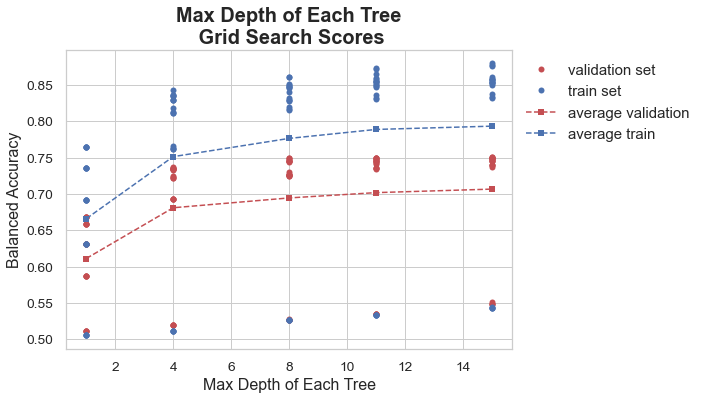

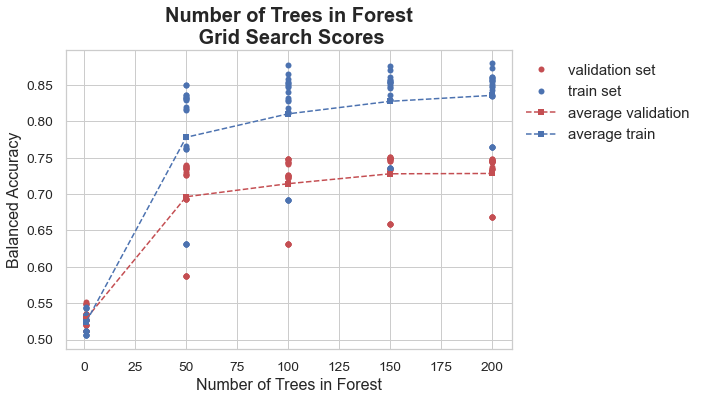

In [12]:
plot_cv_train_test(cv_results, param_1, param_label_1)
plot_cv_train_test(cv_results, param_2, param_label_2)

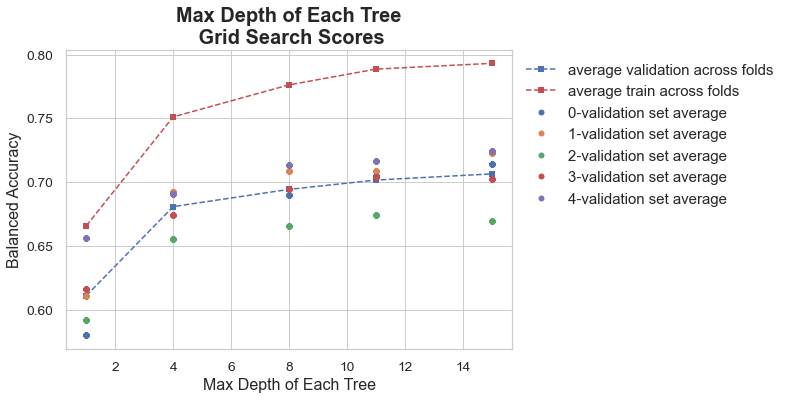

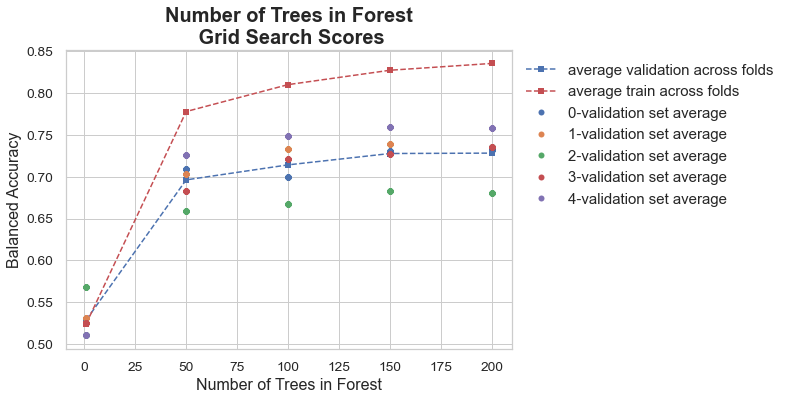

In [13]:
plot_cv_folds(cv_results, param_1, param_label_1, cv_splitter.n_splits)
plot_cv_folds(cv_results, param_2, param_label_2, cv_splitter.n_splits)

## Analysis of mistakes 

In [14]:
tf_rf_best_pipeline = tf_rf_grid_searcher.best_estimator_
analysis_of_mistakes(tf_rf_best_pipeline, x_train_df, y_train)

[[1125   75]
 [ 293  907]]
----- False Positives
Average Length of Sentences:    10.746666666666666
Breakdown of website names:     {'imdb': 0.44, 'amazon': 0.2, 'yelp': 0.36}
Percentage with negation words: 0.4533333333333333
...Examples
...Examples
If you are looking for a good quality Motorola Headset keep looking, this isn't it.
Excellent starter wireless headset.
Were JERKS on the phone.
The BT headset was such a disapoinment.
I have had this phone for over a year now, and I will tell you, its not that great.
The loudspeaker option is great, the bumpers with the lights is very ... appealing.
The internet access was fine, it the rare instance that it worked.
Very Dissapointing Performance.
The plastic breaks really easy on this clip.
However-the riingtones are not the best, and neither are the games.


----- False Negatives
Average Length of Sentences:    10.406143344709898
Breakdown of website names:     {'imdb': 0.3378839590443686, 'amazon': 0.3447098976109215, 'yelp': 0.31740614

## Generate predictions using best Random Forest and Count Vectorizer

In [15]:
# count_rf_filename = os.path.join(output_dir, 'bow_count_rf_yproba1_test.txt')
# test_on_estimator(count_rf_grid_searcher.best_estimator_, x_test_text, count_rf_filename)
tf_rf_filename = os.path.join(output_dir, 'bow_tf_rf_yproba1_test.txt')
test_on_estimator(tf_rf_grid_searcher.best_estimator_, x_test_text, tf_rf_filename)


## L1-Logistic Regression: Hyperparameter Search

In [35]:
lasso = sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE)
# logit_lasso hyperparameter grid
lasso_parameters = {
     'lasso__C': np.logspace(-3, 3, 7),
     'lasso__max_iter': [1, 5, 10, 20], # sneaky way to do "early stopping" 
}
lasso_pipeline_tuple = ('lasso', lasso)


In [36]:
tf_lasso_pipeline = Pipeline([
    tf_pipeline_tuple,
#     count_pipeline_tuple,
    lasso_pipeline_tuple,
 ])
tf_lasso_full_grid = { 
#     **count_parameters,
    **lasso_parameters
}


tf_lasso_grid_searcher = GridSearchCV(
    tf_lasso_pipeline, 
    tf_lasso_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_lasso_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   17.2s
[Parallel(n_jobs=3)]: Done 140 out of 140 | elapsed:   31.7s finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('lasso',
                                        LogisticRegression(penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'lasso__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lasso__max_iter': [1, 5, 10, 20]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [37]:
print_gridsearch_results(tf_lasso_grid_searcher, list(tf_lasso_full_grid.keys()))

Dataframe has shape: (28, 22)
Number of trials used in grid search:  28


,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
27,1000,20,1.000000,0.816667,3.953274,1
23,100,20,1.000000,0.816250,3.225150,2
26,1000,10,1.000000,0.814583,2.016913,3
22,100,10,1.000000,0.813333,1.748726,4
19,10,20,0.995208,0.807917,0.722022,5
25,1000,5,0.995833,0.807500,0.915968,6
21,100,5,0.995104,0.807083,0.877425,7
18,10,10,0.991146,0.805417,0.490527,8
17,10,5,0.984062,0.802500,0.355651,9
24,1000,1,0.887083,0.754583,0.159562,10


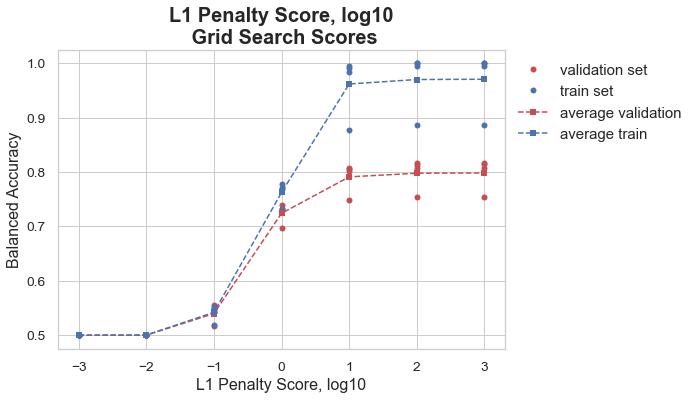

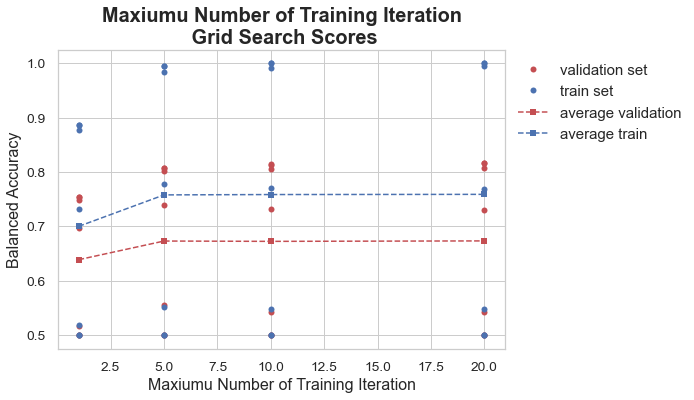

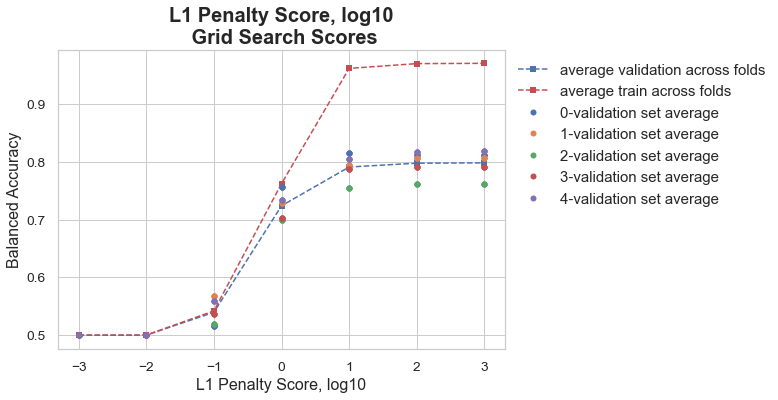

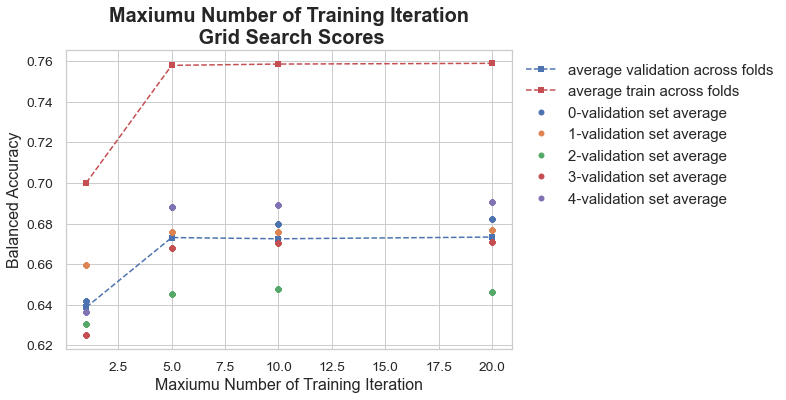

In [38]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_lasso_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
param_1 = "lasso__C"
param_label_1 = "L1 Penalty Score, log10"

param_2 = "lasso__max_iter"
param_label_2 = "Maxiumu Number of Training Iteration"

plot_cv_train_test(cv_results, param_1, param_label_1, log10=True)
plot_cv_train_test(cv_results, param_2, param_label_2)

plot_cv_folds(cv_results, param_1, param_label_1, cv_splitter.n_splits, log10=True)
plot_cv_folds(cv_results, param_2, param_label_2, cv_splitter.n_splits)

In [33]:
tf_lasso_grid_searcher.best_params_

{'lasso__C': 100.0, 'lasso__max_iter': 20}

In [26]:
tf_lasso_best_pipeline = tf_lasso_grid_searcher.best_estimator_
analysis_of_mistakes(tf_lasso_best_pipeline, x_train_df, y_train)

[[1195    5]
 [   3 1197]]
----- False Positives
Average Length of Sentences:    4.8
Breakdown of website names:     {'imdb': 0.4, 'amazon': 0.2, 'yelp': 0.4}
Percentage with negation words: 1.0
...Examples
...Examples
Not good enough for the price.
It is not good.  
Nothing at all to recommend.  
It was not good.
Would not recommend to others.


----- False Negatives
Average Length of Sentences:    3.9166666666666665
Breakdown of website names:     {'imdb': 0.3333333333333333, 'amazon': 0.3333333333333333, 'yelp': 0.3333333333333333}
Percentage with negation words: 0.0
...Examples
...Examples
Would recommend this item.
GO AND SEE IT!  
Will be back again!


----- True Positives
Average Length of Sentences:    11.12531328320802
Breakdown of website names:     {'imdb': 0.3333333333333333, 'amazon': 0.3333333333333333, 'yelp': 0.3333333333333333}
Percentage with negation words: 0.08270676691729323
...Examples
...Examples
The price was very good and with the free shipping and all it was a

## L1-Logistic Regression: Generate Predictions

In [25]:
lasso_filename = os.path.join(output_dir, 'bow_count_lasso_yproba1_test.txt')
test_on_estimator(count_lasso_grid_searcher.best_estimator_, x_test_text, lasso_filename)

# Model 3: Gradient Boosted Trees

## Gradient Boosted Tree: Hyperparameter search

**NOTE** Only re-run when necessary. The total run-time for rebuilding these classifiers is roughly 15-30 minutes.

In [99]:
gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=RANDOM_STATE)
# GradientBoosting-Tree hyperparameter grid
gbtree_parameters = {
    "gbtree__n_estimators": [100, 200, 300],
    "gbtree__max_depth": [5, 10, 20],
    "gbtree__min_samples_leaf": [1, 3, 5],
}
gbtree_pipeline_tuple = ('gbtree', gbtree_classifier)


### Fit on the tfidf_vectorizer

In [100]:
tf_gbtree_pipeline = Pipeline([
    tf_pipeline_tuple,
    gbtree_pipeline_tuple,
 ])
tf_gbtree_full_grid = { 
    **gbtree_parameters
}


tf_gbtree_grid_searcher = GridSearchCV(
    tf_gbtree_pipeline, 
    tf_gbtree_full_grid, 
    cv=cv_splitter, 
    n_jobs=5, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_gbtree_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   17.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:  3.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('gbtree',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   random_state=123))]),
             n_jobs=5,
             param_grid={'gbtree__max_depth': [5, 10, 20],
                         'gbtree__min_samples_leaf': [1, 3, 5],
                         'gbtree__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [101]:
print_gridsearch_results(tf_gbtree_grid_searcher, list(tf_gbtree_full_grid.keys()))

Dataframe has shape: (27, 23)
Number of trials used in grid search:  27


,param_gbtree__n_estimators,param_gbtree__max_depth,param_gbtree__min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
2,300,5,1,0.944375,0.767083,5.463760,1
1,200,5,1,0.926146,0.766667,3.836817,2
18,100,20,1,0.997396,0.766250,7.932168,3
11,300,10,1,0.997396,0.765417,12.468887,4
12,100,10,3,0.901667,0.764583,3.406212,5
9,100,10,1,0.938333,0.764583,5.025189,6
4,200,5,3,0.891875,0.763750,2.794438,7
19,200,20,1,0.997396,0.763333,14.986060,8
5,300,5,3,0.917292,0.762917,4.296157,9
10,200,10,1,0.997083,0.762500,8.905724,10


### GBTree: Explore CV Results in Visualization

In [102]:
def plot_cv_folds(cv_results, param_name, param_label, folds, log10=False, log2=False):
    # Transform CV Results into a DF
    param_name = f'param_{param_name}'
    cv_results_df = pd.DataFrame(cv_results).sort_values(param_name)
    mean_test_score = cv_results_df['mean_test_score'].values
    mean_train_score = cv_results_df['mean_train_score'].values
    param_values = cv_results_df[param_name].values
    x_values = param_values.astype(np.float64)

    # Get x_values
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)

    _, ax = plt.subplots(1, 1)

    # Get the overall mean values for all other hyperparameter combinations at this particular param1-hyperparameter value
    average_test_x = []
    average_train_x = []
    for i, value in enumerate(param_values):
        value_idx = np.where(param_values == value)
        average_train_x.append(np.mean(mean_train_score[value_idx]))
        average_test_x.append(np.mean(mean_test_score[value_idx]))
    ax.plot(x_values, average_test_x, '--sb', label=f'average validation across folds')

    # Get overall mean_train_score
    for fold in range(folds):
        fold_scores = cv_results_df[f'split{fold}_test_score'].values
        average_fold_scores = []
        for i, value in enumerate(param_values):
            value_idx = np.where(param_values == value)
            average_fold_scores.append(np.mean(fold_scores[value_idx]))
        ax.plot(x_values, average_fold_scores, 'o', label=f'{fold}-validation set average')

    ax.set_title(f"{param_label}\n Variation Across Folds", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1, 1))


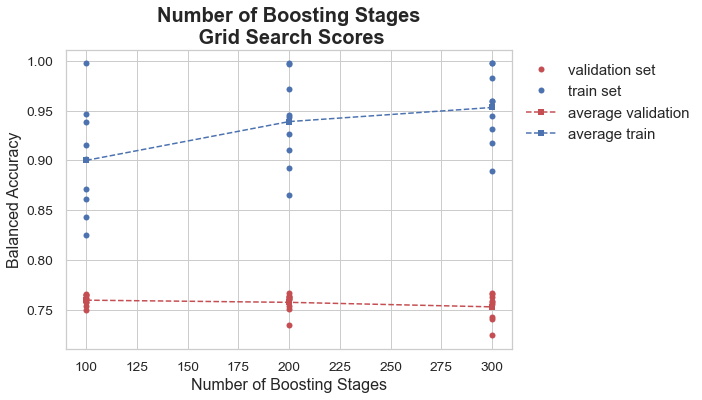

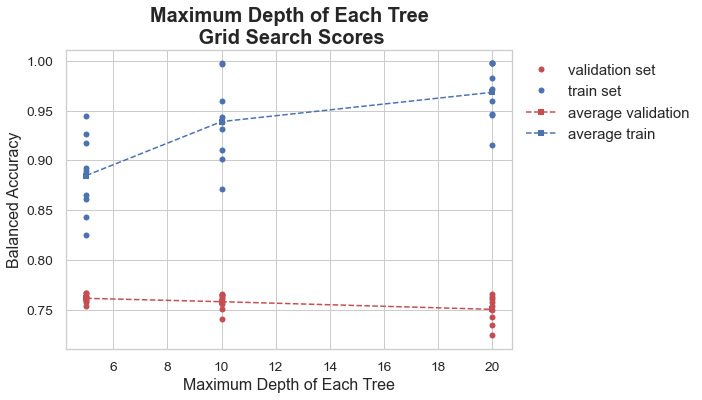

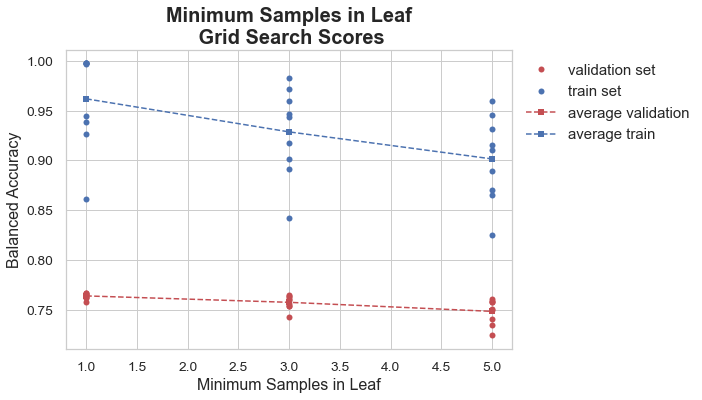

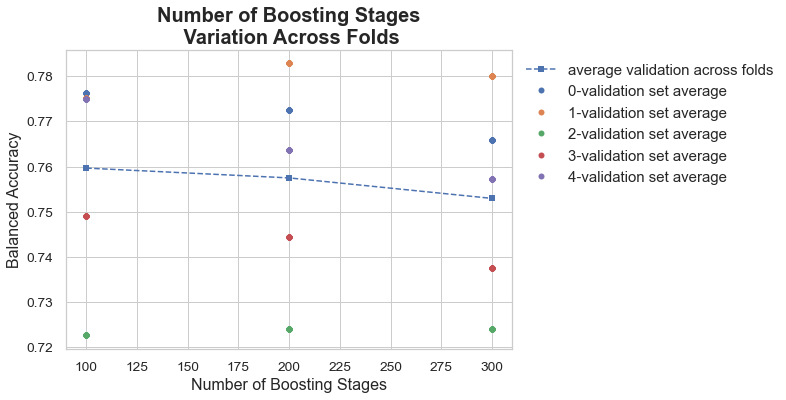

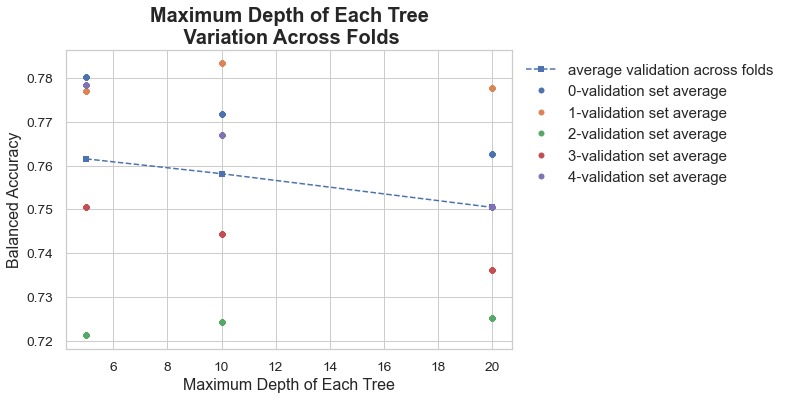

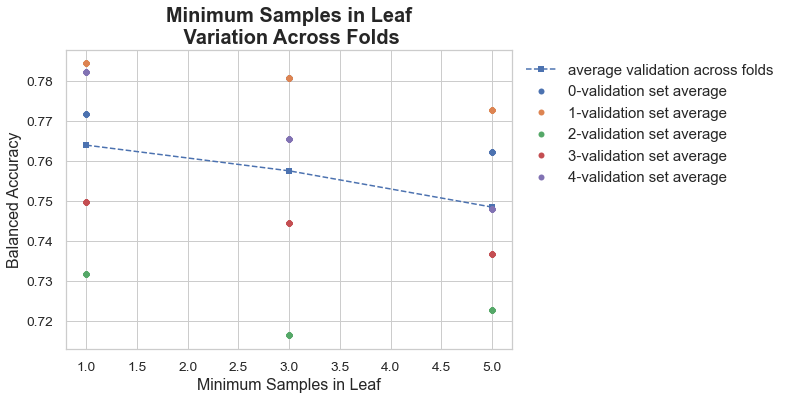

In [103]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_gbtree_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
param_1 = "gbtree__n_estimators"
param_label_1 = "Number of Boosting Stages"

param_2 = "gbtree__max_depth"
param_label_2 = "Maximum Depth of Each Tree"

param_3 = "gbtree__min_samples_leaf"
param_label_3 = "Minimum Samples in Leaf"

plot_cv_train_test(cv_results, param_1, param_label_1)
plot_cv_train_test(cv_results, param_2, param_label_2)
plot_cv_train_test(cv_results, param_3, param_label_3)

plot_cv_folds(cv_results, param_1, param_label_1, cv_splitter.n_splits)
plot_cv_folds(cv_results, param_2, param_label_2, cv_splitter.n_splits)
plot_cv_folds(cv_results, param_3, param_label_3, cv_splitter.n_splits)

In [105]:
tf_gbtree_grid_searcher.best_params_

{'gbtree__max_depth': 5,
 'gbtree__min_samples_leaf': 1,
 'gbtree__n_estimators': 300}

### GBTree: Explore mistakes and successes

In [106]:
tf_gbtree_best_pipeline = tf_gbtree_grid_searcher.best_estimator_
analysis_of_mistakes(tf_gbtree_best_pipeline, x_train_df, y_train)

[[1183   17]
 [ 135 1065]]
----- False Positives
Average Length of Sentences:    10.235294117647058
Breakdown of website names:     {'imdb': 0.29411764705882354, 'amazon': 0.17647058823529413, 'yelp': 0.5294117647058824}
Percentage with negation words: 0.7058823529411765
...Examples
...Examples
I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
The loudspeaker option is great, the bumpers with the lights is very ... appealing.
Not good enough for the price.
It is not good.  
The only place good for this film is in the garbage.  
Nothing at all to recommend.  
The performances are not improved by improvisation, because the actors now have twice as much to worry about: not only whether they're delivering the line well, but whether the line itself is any good.  
And, quite honestly, often its not very good.  
The food is about on par with Denny's, which is to say, not good at all.
Not good for the money.


----- False Negatives
Average Leng

## GBTree: Generate Predictions

In [37]:
gbtree_filename = os.path.join(output_dir, 'bow_tf_gbtree_yproba1_test.txt')
test_on_estimator(tf_gbtree_grid_searcher.best_estimator_, x_test_text, gbtree_filename)

# Model 4: MLP Classifier

## MLP Classifier: Hyperparameter Search

In [94]:
mlp = sklearn.neural_network.MLPClassifier(solver='lbfgs', random_state=RANDOM_STATE)
mlp_parameters = {
    'mlp__hidden_layer_sizes': [16, 32, 64],
    'mlp__alpha': [0.0001,0.01,1, 10],
    'mlp__max_iter': [50, 100, 200, 500], # sneaky way to do "early stopping" 
}
mlp_pipeline_tuple = ('mlp', mlp)

In [95]:
tf_mlp_pipeline = Pipeline([
    tf_pipeline_tuple,
    mlp_pipeline_tuple,
 ])
tf_mlp_full_grid = { 
#     **tf_parameters,
    **mlp_parameters
}


tf_mlp_grid_searcher = GridSearchCV(
    tf_mlp_pipeline, 
    tf_mlp_full_grid, 
    cv=cv_splitter, 
    n_jobs=5, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_mlp_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   15.7s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  9.9min finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('mlp',
                                        MLPClassifier(random_state=123,
                                                      solver='lbfgs'))]),
             n_jobs=5,
             param_grid={'mlp__alpha': [0.0001, 0.01, 1, 10],
                         'mlp__hidden_layer_sizes': [16, 32, 64],
                         'mlp__max_iter': [50, 100, 200, 500]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [96]:
print_gridsearch_results(tf_mlp_grid_searcher, list(tf_mlp_full_grid.keys()))

Dataframe has shape: (48, 23)
Number of trials used in grid search:  48


,param_mlp__hidden_layer_sizes,param_mlp__alpha,param_mlp__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
40,32,10,50,0.993958,0.799583,6.351150,1
46,64,10,200,0.993958,0.799167,29.698106,2
41,32,10,100,0.993854,0.799167,7.653727,2
43,32,10,500,0.993854,0.799167,8.689612,2
42,32,10,200,0.993854,0.799167,8.274856,2
47,64,10,500,0.993958,0.798750,27.190499,6
45,64,10,100,0.993854,0.798333,20.408476,7
36,16,10,50,0.993958,0.797917,3.421377,8
44,64,10,50,0.993854,0.797917,12.861723,8
39,16,10,500,0.993958,0.797500,3.867837,10


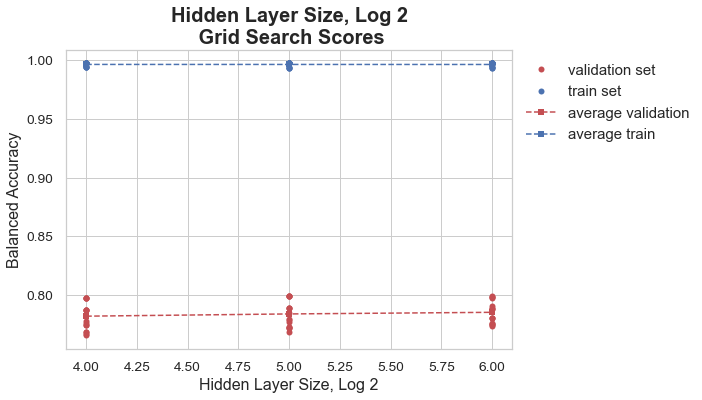

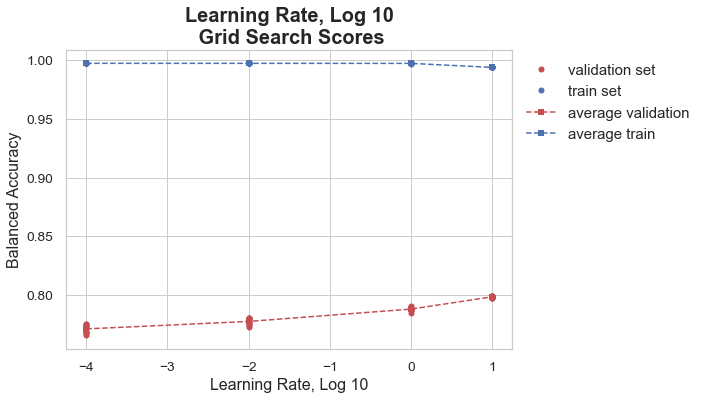

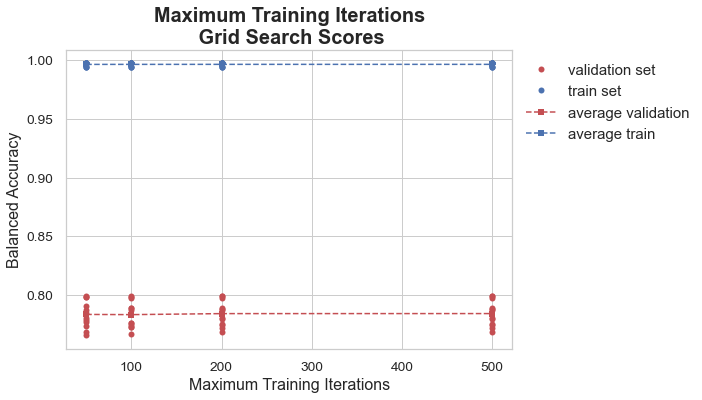

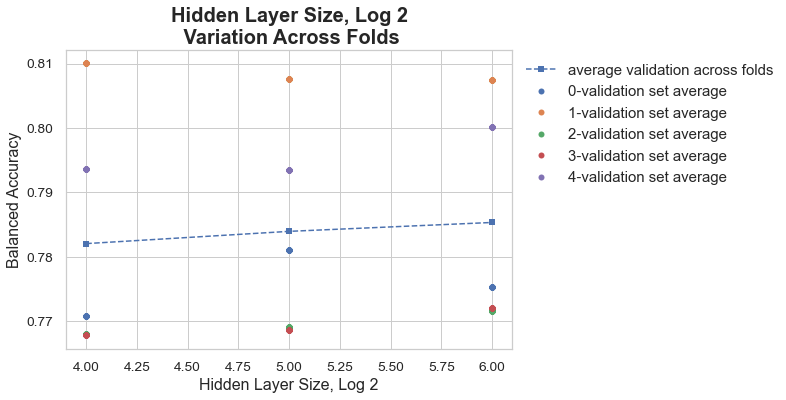

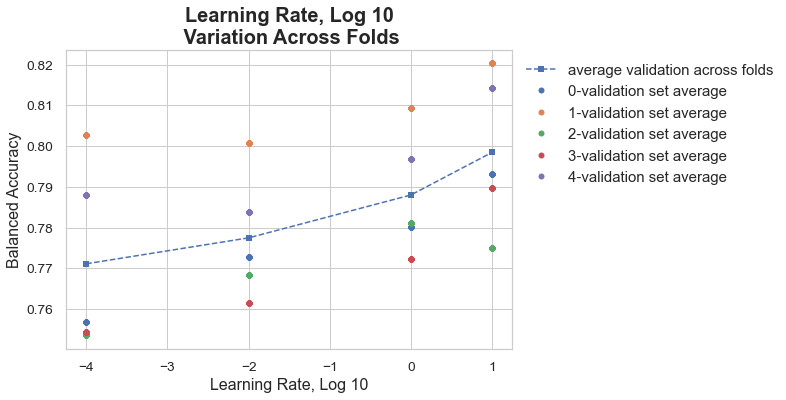

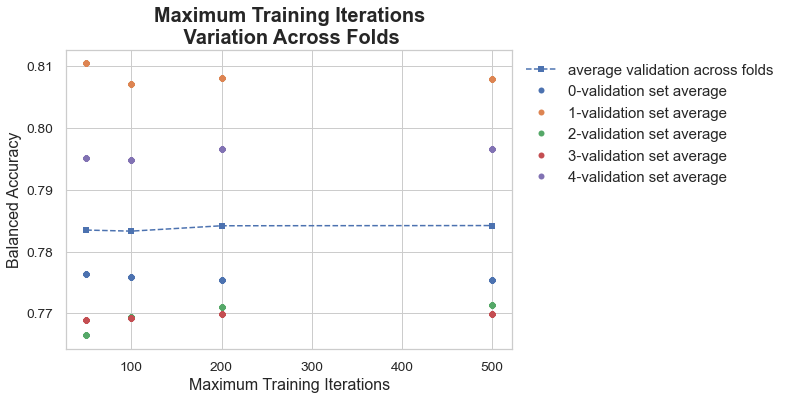

In [97]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_mlp_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
param_1 = "mlp__hidden_layer_sizes"
param_label_1 = "Hidden Layer Size, Log 2"

param_2 = "mlp__alpha"
param_label_2 = "Learning Rate, Log 10"

param_3 = "mlp__max_iter"
param_label_3 = "Maximum Training Iterations"

plot_cv_train_test(cv_results, param_1, param_label_1, log2=True)
plot_cv_train_test(cv_results, param_2, param_label_2, log10=True)
plot_cv_train_test(cv_results, param_3, param_label_3)

plot_cv_folds(cv_results, param_1, param_label_1, cv_splitter.n_splits, log2=True)
plot_cv_folds(cv_results, param_2, param_label_2, cv_splitter.n_splits, log10=True)
plot_cv_folds(cv_results, param_3, param_label_3, cv_splitter.n_splits)

In [98]:
tf_mlp_best_pipeline = tf_mlp_grid_searcher.best_estimator_
analysis_of_mistakes(tf_mlp_best_pipeline, x_train_df, y_train)

[[1193    7]
 [  10 1190]]
----- False Positives
Average Length of Sentences:    5.571428571428571
Breakdown of website names:     {'imdb': 0.5714285714285714, 'amazon': 0.14285714285714285, 'yelp': 0.2857142857142857}
Percentage with negation words: 0.7142857142857143
...Examples
...Examples
Not good enough for the price.
Graphics is far from the best part of the game.  
It is not good.  
Why was this film made?  
Nothing at all to recommend.  
It was not good.
Would not recommend to others.


----- False Negatives
Average Length of Sentences:    5.3
Breakdown of website names:     {'imdb': 0.6, 'amazon': 0.2, 'yelp': 0.2}
Percentage with negation words: 0.4
...Examples
...Examples
Just what I wanted.
Would recommend this item.
GO AND SEE IT!  
Predictable, but not a bad watch.  
The last 15 minutes of movie are also not bad as well.  
Waste your money on this game.  
The soundtrack wasn't terrible, either.  
I don't think you will be disappointed.  
This place has it!
Will be back ag

In [87]:
mlp_filename = os.path.join(output_dir, 'bow_tf_mlp_yproba1_test.txt')
test_on_estimator(tf_mlp_grid_searcher.best_estimator_, x_test_text, mlp_filename)

# Archive: Things We May Need 



In [39]:
# np.argwhere(count_rf_grid_searcher.cv_results_["rank_test_score"] == 1)
# count_rf_grid_searcher.cv_results_["mean_train_score"][29]


## Construction of two vectorizers - counts and tfidf


In [8]:
# count_vectorizer = CountVectorizer(stop_words='english')
# # #  Parameters for grid search
# # count_parameters = {
# #     'count__min_df': np.arange(1, 3),
# #     'count__max_df': (0.05, 0.5),
# #     'count__ngram_range': [(1, 1), (1, 2)],
# # }

# # Static Parameters based on earlier grid_search 
# count_vectorizer.set_params(min_df = 1, ngram_range = (1,2))


# # Set the tuple for the pipeline
# count_pipeline_tuple = ("count", count_vectorizer)


In [40]:
# random_forest_grid_searcher.fit(x_train_text_count, y_train)

In [41]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [42]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

### Fit on TFIDF

In [43]:
# random_forest_grid_searcher.fit(x_train_text_tf, y_train)

In [44]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [45]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [56]:
# best_random_forest = random_forest_classifier.set_params(**random_forest_grid_searcher.best_params_)
# best_random_forest.fit(x_train_text_count, y_train)

In [47]:
# # Gradient Boosted Tree classifier with default values
# gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=100)

In [48]:
# # Gradient Boosted Tree hyperparameter grid
# gbtree_parameter_grid = dict(
#     n_estimators = [20, 50, 100],
#     max_depth = [5, 10],
#     #min_samples_leaf = [1, 3, 5],
#     #random_state=[101, 202],  # try two possible seeds to initialize parameters
#     random_state=[100],
#     )

In [49]:
# gbtree_grid_searcher = sklearn.model_selection.GridSearchCV(
#     gbtree_classifier,
#     gbtree_parameter_grid,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [50]:
# gbtree_grid_searcher.fit(x_train_text_count, y_train)

In [51]:
# gbtree_grid_search_results_df = pd.DataFrame(gbtree_grid_searcher.cv_results_).copy()
# n_trials_grid_search = gbtree_grid_search_results_df.shape[0]

In [52]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# gbtree_grid_search_results_df.sort_values(param_keys, inplace=True)

In [53]:
# gbtree_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [54]:
# best_gbtree = gbtree_classifier.set_params(**gbtree_grid_searcher.best_params_)
# best_gbtree.fit(x_train_text_count, y_train)

In [63]:
# best_gbtree_yhat_test = best_gbtree.predict(x_test_text_count)
# with open('bow_gbtree_countvectorizer_test_preds.txt', 'w') as f:
#     for pred in best_gbtree_yhat_test:
#         f.write(str(pred) + '\n')

In [64]:
# lasso = sklearn.linear_model.LogisticRegression(
#     penalty='l1', solver='saga', random_state=101)

In [65]:
# lasso_hyperparameter_grid_by_name = dict(
#     C=np.logspace(-4, 4, 9),
#     max_iter=[20, 40], # sneaky way to do "early stopping" 
#                        # we'll take either iter 20 or iter 40 in training process, by best valid performance
#     )

In [66]:
# lasso_searcher = sklearn.model_selection.GridSearchCV(
#     lasso,
#     lasso_hyperparameter_grid_by_name,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [67]:
# lasso_searcher.fit(x_train_text_count, y_train)

In [68]:
# lasso_search_results_df = pd.DataFrame(lasso_searcher.cv_results_).copy()

In [69]:
# param_keys = ['param_C', 'param_max_iter']

# # Rearrange row order so it is easy to skim
# lasso_search_results_df.sort_values(param_keys, inplace=True)

In [70]:
# lasso_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [71]:
# best_lasso = lasso.set_params(**lasso_searcher.best_params_)
# best_lasso.fit(x_train_text_count, y_train)

In [72]:
# best_lasso_yhat_test = best_lasso.predict_proba(x_test_text_count)[:,1]
# np.savetxt('yproba1_test.txt', best_lasso_yhat_test)

### RF: Fit on CountVector

In [40]:
count_rf_pipeline = Pipeline([
    count_pipeline_tuple,
    rf_pipeline_tuple,
 ])
count_rf_full_grid = { 
#     **count_parameters,
    **rf_parameters
}


count_rf_grid_searcher = GridSearchCV(
    count_rf_pipeline, 
    count_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    return_train_score=True,
    scoring='balanced_accuracy'
)
count_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.3s


KeyboardInterrupt: 

In [15]:
print_gridsearch_results(count_rf_grid_searcher, list(count_rf_full_grid.keys()))

Dataframe has shape: (50, 25)
Number of trials used in grid search:  50


,param_rf__max_depth,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
10,102.837,0.918541,0.775046,0.934253,1
6,62.102,0.907567,0.773368,0.666190,2
8,82.4694,0.915276,0.773365,0.792648,3
4,41.7347,0.898679,0.773363,0.617309,4
9,92.6531,0.916874,0.771714,0.856381,5
5,51.9184,0.902707,0.771692,0.668766,6
11,113.02,0.922429,0.769212,0.978202,7
7,72.2857,0.911109,0.768758,0.728714,8
49,500,0.997153,0.768744,1.807710,9
48,489.816,0.997153,0.767493,1.821891,10


In [ ]:
cv_results = count_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(rf_parameters.keys())[0]
param_label = "Max Depth of trees"

plot_cv_single_param(cv_results, param, param_label)


In [17]:
count_rf_grid_searcher.best_params_

{'rf__max_depth': 102.83673469387756}